## Tobigs 8주차 NLP Basic 과제
#### 15기 이윤정
---
#### NLP 제대로 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [61]:
# 필요한 모듈 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
import string

## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 8주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [62]:
spam = pd.read_csv('./spam.csv')
spam

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [63]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [64]:
spam.iloc[5540]['v2']

'ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O å£250 3 WANT å£800'

대문자로만 존재하는 텍스트도 존재한다. Free, FREE, free 모두 동일한 단어지만 모델은 다르게 인식한다. 그렇기 때문에 모두 소문자로 변환하거나 대문자로 변환하는 과정을 거쳐 1번만 등장하는 단어를 줄인다.

In [65]:
#소문자 화
spam['v2'] = spam['v2'].str.lower()

In [66]:
spam.isnull().sum()

v1    0
v2    0
dtype: int64

결측치는 존재하지 않는다.

In [67]:
spam.shape

(5572, 2)

In [68]:
spam['v1'].unique()

array(['ham', 'spam'], dtype=object)

In [69]:
spam['v1'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: v1, dtype: float64

정상 데이터와 스팸 데이터가 86.6:13.4의 비율로 존재한다. - 불균형한 데이터

In [70]:
spam['v2'].describe()

count                       5572
unique                      5168
top       sorry, i'll call later
freq                          30
Name: v2, dtype: object

텍스트의 경우 5572개 중 5168개가 unique하므로 404개는 중복된 데이터이다.이때, "sorry, i'll call later"라는 데이터는 30번이 중복되었다. 중복된 데이터는 제외해주자

In [71]:
spam = spam.drop_duplicates('v2')

## Tokenizing
- 실습코드에서는 한국어 대상이라 konlpy를 다뤘지만, 영어는 nltk 모듈을 쓸 수 있습니다. 의미 있는 토큰으로 쪼개고 불용어도 처리해보세요! 현존하는 불용어 리스트를 사용해도 좋고, 새롭게 만들어도 좋습니다. 특수문자는 없애주고, 모두 소문자로 변환해주는 전처리도 필요하겠죠?

### 토큰 생성 (tokenize)
Corpus에서 token이라 불리는 단위로 나누어 주는 작업을 의미한다. 

In [72]:
import nltk

In [73]:
!pip3 show nltk

Name: nltk
Version: 3.5
Summary: Natural Language Toolkit
Home-page: http://nltk.org/
Author: Steven Bird
Author-email: stevenbird1@gmail.com
License: Apache License, Version 2.0
Location: c:\programdata\anaconda3\lib\site-packages
Requires: tqdm, joblib, click, regex
Required-by: 


In [74]:
#nltk의 punkt 다운로드
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tldus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
from nltk.tokenize import word_tokenize

nltk.download('punkt')
print(word_tokenize(spam.iloc[5]['v2']))

['freemsg', 'hey', 'there', 'darling', 'it', "'s", 'been', '3', 'week', "'s", 'now', 'and', 'no', 'word', 'back', '!', 'i', "'d", 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', '?', 'tb', 'ok', '!', 'xxx', 'std', 'chgs', 'to', 'send', ',', 'å£1.50', 'to', 'rcv']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tldus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [76]:
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
print(tokenizer.tokenize(spam.iloc[5]['v2']))

['freemsg', 'hey', 'there', 'darling', 'it', "'s", 'been', '3', 'week', "'s", 'now', 'and', 'no', 'word', 'back', '!', 'i', "'d", 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', '?', 'tb', 'ok', '!', 'xxx', 'std', 'chgs', 'to', 'send', ',', 'å£1.50', 'to', 'rcv']


word_tokenize() 함수는 TreebankWordTokenizer 클래스의 인스턴스에 tokenize() 함수를 호출하는 래퍼 함수이다. word_tokenize() 함수는 스페이스와 구두점을 이용해 단어를 분해하며, 구두점을 버리지는 않는다. 

이때, TreebankWordTokenizer 클래스는 Penn Treebank 말뭉치 규약을 사용한다. 이는 1980년대 저널 기사를 기반으로 만들어 졌으며, 주요 규약 중 하나가 축약형을 분리하는 것이다. 

In [77]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
print(tokenizer.tokenize(spam.iloc[5]['v2']))

['freemsg', 'hey', 'there', 'darling', 'it', "'", 's', 'been', '3', 'week', "'", 's', 'now', 'and', 'no', 'word', 'back', '!', 'i', "'", 'd', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', '?', 'tb', 'ok', '!', 'xxx', 'std', 'chgs', 'to', 'send', ',', 'å', '£', '1', '.', '50', 'to', 'rcv']


또 다른 Tokenizer인 WordPunctTokenizer를 사용해보았다. WordPunctTokenizer는 word_tokenizer과 달리 모든 구두점을 단위로 분해를 한다.  

In [78]:
# 특수문자 제거
import re

word = re.sub("[^a-zA-Z]", " ", spam.iloc[5]['v2'])
tokenizer = WordPunctTokenizer()
words = tokenizer.tokenize(word)
print(words)

['freemsg', 'hey', 'there', 'darling', 'it', 's', 'been', 'week', 's', 'now', 'and', 'no', 'word', 'back', 'i', 'd', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'to', 'send', 'to', 'rcv']


영어를 제외한 특수문자 및 숫자는 필요없다고 판단되어 정규표현식을 통해 알파벳으로 구성된 텍스트만 남기었다. 이때, 앞서 사용한 Tokenizer들의 차이는 구두점을 포함하여 분해하는 지의 여부였는 데, 정규표현식을 통해 알파벳만 남기었으므로 어떤 Tokenizer를 사용해도 상관없다고 생각되어 WordPunctTokenizer()를 사용하였다. 

### 불용어 제외
불용어란 일반적으로 corpus에서 자주 나타나는 단어로 학습이나 예측 시 기여를 하지 않는다. (조사, 접미사 등) NLTK에서는 17개의 언어에 대한 불용어가 정의되어 있다. 불용어를 제거 하기 위해선 불용어 사전에 있는 단어를 제거하면 된다.

In [79]:
from nltk.corpus import stopwords

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))  #불용어 사전 - 영어
words = [word for word in words if word not in english_stopwords]
print(words)

['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tldus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 표제어 추출(Lemmatization)
표제어란 사전형 단어를 의미한다. 그러므로, 표제어 추출은 단어들로부터 표제어를 찾아가는 과정이라고 볼 수 있다. 표제어 추출은 단어들이 다른 형태를 가지더라도, 그 뿌리 단어를 찾아가서 단어의 개수를 줄일 수 있는지 판단합니다. 예를 들자면 am, are, is의 표제어는 be이다.

In [80]:
from nltk.stem import WordNetLemmatizer

text = words
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
text = [lemmatizer.lemmatize(word) for word in text]
print(text)

['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tldus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 어간 추출 (stemming)
어간이란 단어의 의미를 담고 있는 단어의 핵심부분을 의미한다. 대표적으로 포터 스태머(PorterStemmer)와 랭커스터 스태머(LancasterStemmer)가 있는데 포터는 보수적이고 랭커스터는 좀 더 적극적이다.

In [81]:
text = words
stemmer = nltk.stem.PorterStemmer()
text = [stemmer.stem(word) for word in text]
print(text)

['freemsg', 'hey', 'darl', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chg', 'send', 'rcv']


In [82]:
text = words
stemmer = nltk.stem.LancasterStemmer()
text = [stemmer.stem(word) for word in text]
print(text)

['freemsg', 'hey', 'darl', 'week', 'word', 'back', 'lik', 'fun', 'stil', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']


포터 스태머와 랭커스터 스태머를 통해 각각 어간 추출을 진행한 결과 대부분 유사하지만, 'like'라는 단어를 다룰 때 포터스태머와 달리 랭커스터스태머는 'lik'로 어간을 추출하였다.

표제어 추출과 어간 추출 모두 단어를 일반화 시켜, 문서 내의 단어 수를 줄이는 데 목적이 있다. 동일한 텍스트를 일반화 시킨 결과 표제어 추출이 가장 텍스트의 의미를 해치지 않는 선에서 일반화 된다고 판단되어 표제어 추출을 사용하였다.  

- **WordNetLemmatizer** : `darling, like`  
- **PorterStemmer** : `darl, like`  
- **LancasterStemmer** : `darl, lik`

In [83]:
##최종 tokenizing
token = []  #단어 임베딩에 사용되는 모델의 input type이 리스트 형태이므로 리스트 형태로 저장

for i in range(0, len(spam)):

    # 특수문자 제거
    words = re.sub('[^a-zA-Z]', ' ', spam.iloc[i]['v2'])  
    
    # tokenize
    tokenizer = WordPunctTokenizer()
    words = tokenizer.tokenize(words)  
    
    # 불용어 제거
    english_stopwords = set(stopwords.words('english'))
    words = [word for word in words if word not in english_stopwords] 
    
    # 표제어추출
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  
    token.append(words)

In [84]:
print(token)

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'u', 'oni'], ['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply'], ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'], ['nah', 'think', 'go', 'usf', 'life', 'around', 'though'], ['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv'], ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aid', 'patent'], ['per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'set', 'callertune', 'caller', 'press', 'copy', 'friend', 'callertune'], ['winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hour'], ['mobile', 'month', 'u', 'r',

## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)

### CBOW
CBOW는 주변에 있는 단어들을 가지고, 중간에 있는 단어들을 예측하는 방법이다.   
`중심 단어(target)` : 예측해야하는 단어  
`주변 단어(context)` : 예측에 사용되는 단어  

- sg = 0 : CBOW 
- size : 벡터 크기
- window : 윈도우 크기 (중심 단어를 맞추기위해 앞 뒤 단어들을 n 개까지 볼 것인지 정하는 척도)
- min_count : 최소 n번 이상 등장한 단어 (n회 이하 단어 무시)
- workers : 동시에 처리할 작업 수(코어 수와 비슷하게 설정)

In [85]:
from gensim.models import Word2Vec

CBOW = Word2Vec(sentences=token, sg = 0, size = 2, window = 3, min_count=1 , workers = 2, iter=1000)
CBOW_words = CBOW.wv.index2word
CBOW_vocabs = CBOW.wv.vocab.keys()
CBOW_vectors = CBOW.wv.vectors  #학습된 단어 임베딩

앞서, 중복된 단어는 모두 제거했으므로 min_count는 1로 설정한다. 

In [86]:
cbow = pd.DataFrame(CBOW_vectors, columns = ['v1', 'v2'])
cbow['words'] = CBOW_words
cbow = cbow[['words', 'v1', 'v2']]
cbow

,words,v1,v2
0,u,-0.820151,-0.132372
1,call,0.214006,2.721229
2,get,-0.408987,0.740906
3,ur,-0.218377,0.902268
4,go,-1.205363,-0.828943
...,...,...,...
7038,heap,-0.629805,0.223881
7039,lowes,-3.157424,-3.482952
7040,salesman,-2.033298,-2.012935
7041,pity,-1.225612,0.610855


In [87]:
# 가장 유사한 단어 5개(topm) 추출
CBOW.most_similar('free', topn=5)

<ipython-input-87-12e9530d7b6c>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  CBOW.most_similar('free', topn=5)


[('java', 1.0000001192092896),
 ('footbl', 1.0000001192092896),
 ('lovingly', 1.0),
 ('corrct', 1.0),
 ('blu', 1.0)]

In [88]:
CBOW.most_similar('morning', topn=5)

<ipython-input-88-e8f5a6b66ba7>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  CBOW.most_similar('morning', topn=5)


[('seen', 1.0),
 ('sapna', 1.0),
 ('apt', 0.9999998807907104),
 ('parent', 0.9999998807907104),
 ('jacuzzi', 0.9999997615814209)]

In [89]:
CBOW.most_similar('mobile', topn=5)

<ipython-input-89-1eb755defcca>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  CBOW.most_similar('mobile', topn=5)


[('kit', 1.0000001192092896),
 ('aco', 1.0),
 ('gsex', 1.0),
 ('update', 1.0),
 ('smsservices', 1.0)]

In [90]:
CBOW.most_similar('service', topn=5)

<ipython-input-90-b1bbe5224dbb>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  CBOW.most_similar('service', topn=5)


[('min', 1.0),
 ('instant', 1.0),
 ('po', 1.0),
 ('freefone', 1.0),
 ('enufcredeit', 1.0)]

도출된 단어 간의 유사성을 체감할 수 없다.

### Skip-grams
Skip-gram은 중심 단어에서 주변 단어를 예측하는 방법이다.  
`주변 단어(target)` : 예측해야 하는 단어  
`중심 단어(context)` : 예측에 사용되는 단어  

- sg = 1 : Skip-grams 
- size : 벡터 크기
- window : 윈도우 크기 (중심 단어를 맞추기위해 앞 뒤 단어들을 n 개까지 볼 것인지 정하는 척도)
- min_count : 최소 n번 이상 등장한 단어 (n회 이하 단어 무시)
- workers : 동시에 처리할 작업 수(코어 수와 비슷하게 설정)

In [91]:
SkGram = Word2Vec(sentences=token, sg = 1, size = 2, window = 3, min_count=1 , workers = 2, iter=1000)
SkGram_words = SkGram.wv.index2word
SkGram_vocabs = SkGram.wv.vocab.keys()
SkGram_vectors = SkGram.wv.vectors  #학습된 단어 임베딩

In [92]:
skgram = pd.DataFrame(SkGram_vectors, columns = ['v1', 'v2'])
skgram['words'] = SkGram_words
skgram = skgram[['words', 'v1', 'v2']]
skgram

,words,v1,v2
0,u,-0.887174,0.546762
1,call,0.045047,1.934780
2,get,-0.555192,0.803116
3,ur,-0.403427,0.931095
4,go,-1.204478,0.384769
...,...,...,...
7038,heap,-2.222185,0.053986
7039,lowes,-3.502667,-0.095976
7040,salesman,-1.643515,0.238306
7041,pity,-0.428544,0.789854


In [93]:
SkGram.most_similar('free', topn=5)

<ipython-input-93-312b525f017d>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  SkGram.most_similar('free', topn=5)


[('price', 1.0),
 ('erode', 0.9999999403953552),
 ('request', 0.9999998807907104),
 ('easter', 0.9999998807907104),
 ('wither', 0.9999998807907104)]

In [94]:
SkGram.most_similar('morning', topn=5)

<ipython-input-94-678b2dce7f3c>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  SkGram.most_similar('morning', topn=5)


[('forgot', 1.0),
 ('slp', 1.0),
 ('dwn', 1.0),
 ('reception', 1.0),
 ('others', 0.9999999403953552)]

In [95]:
SkGram.most_similar('mobile', topn=5)

<ipython-input-95-b2bf94d1bdf4>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  SkGram.most_similar('mobile', topn=5)


[('sf', 1.0),
 ('maximize', 1.0),
 ('keralacircle', 1.0),
 ('savamob', 1.0),
 ('phoenix', 0.9999999403953552)]

In [96]:
SkGram.most_similar('service', topn=5)

<ipython-input-96-fe625eb4006d>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  SkGram.most_similar('service', topn=5)


[('coach', 1.0000001192092896),
 ('voucher', 1.0),
 ('loyalty', 0.9999999403953552),
 ('optical', 0.9999998807907104),
 ('utele', 0.9999998807907104)]

CBOW보다는 유사한 단어를 확인할 수 있다.   
free - price  
morning - busy  
mobile - downloads  
service = loyalty, gifted

In [97]:
from gensim.models import FastText

Fastext = FastText(sentences=token, sg = 1, size = 2, window = 3, min_count=1 , workers = 2, iter=1000)
Fastext_words = Fastext.wv.index2word
Fastext_vocabs = Fastext.wv.vocab.keys()
Fastext_vectors = Fastext.wv.vectors

In [98]:
fastext = pd.DataFrame(Fastext_vectors, columns = ['v1', 'v2'])
fastext['words'] = Fastext_words
fastext = fastext[['words', 'v1', 'v2']]
fastext

,words,v1,v2
0,u,0.410056,-0.362291
1,call,1.761958,0.517931
2,get,0.843433,-0.271001
3,ur,0.791359,-0.109870
4,go,0.574656,-0.752431
...,...,...,...
7038,heap,0.630231,-1.536673
7039,lowes,0.889603,-2.999152
7040,salesman,0.735127,-1.446586
7041,pity,0.831328,-0.209517


In [99]:
Fastext.most_similar('free', topn=5)

<ipython-input-99-2470519569f9>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  Fastext.most_similar('free', topn=5)


[('nz', 1.0),
 ('soonlots', 1.0),
 ('jsco', 0.9999999403953552),
 ('colour', 0.9999998807907104),
 ('wadebridge', 0.9999998211860657)]

In [100]:
Fastext.most_similar('morning', topn=5)

<ipython-input-100-404e35dd9938>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  Fastext.most_similar('morning', topn=5)


[('lasting', 1.0000001192092896),
 ('wuld', 1.0),
 ('inst', 1.0),
 ('alone', 1.0),
 ('fly', 1.0)]

In [101]:
Fastext.most_similar('mobile', topn=5)

<ipython-input-101-eaa0cea24d69>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  Fastext.most_similar('mobile', topn=5)


[('rgent', 1.0),
 ('bluray', 1.0),
 ('outage', 1.0),
 ('gaytextbuddy', 1.0),
 ('deck', 0.9999999403953552)]

In [102]:
Fastext.most_similar('service', topn=5)

<ipython-input-102-7fcbb66d065b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  Fastext.most_similar('service', topn=5)


[('tune', 1.0),
 ('island', 0.9999999403953552),
 ('suman', 0.9999999403953552),
 ('loyalty', 0.9999998807907104),
 ('cast', 0.9999998807907104)]

CBOW보다는 유사한 단어를 확인할 수 있으나, Skip-grams보다 유사한 단어의 수가 적다.  
mobile - camcorder  
service = offering  

따라서, 임베딩은 Skip-grams으로 결정하였다. 

## 본인이 도출해낸 해석을 적어주세요!

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.

#### PCA

In [105]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

pca = PCA(n_components=2)
xys = pca.fit_transform(SkGram_vectors)
xs = xys[:,0]
ys = xys[:,1]

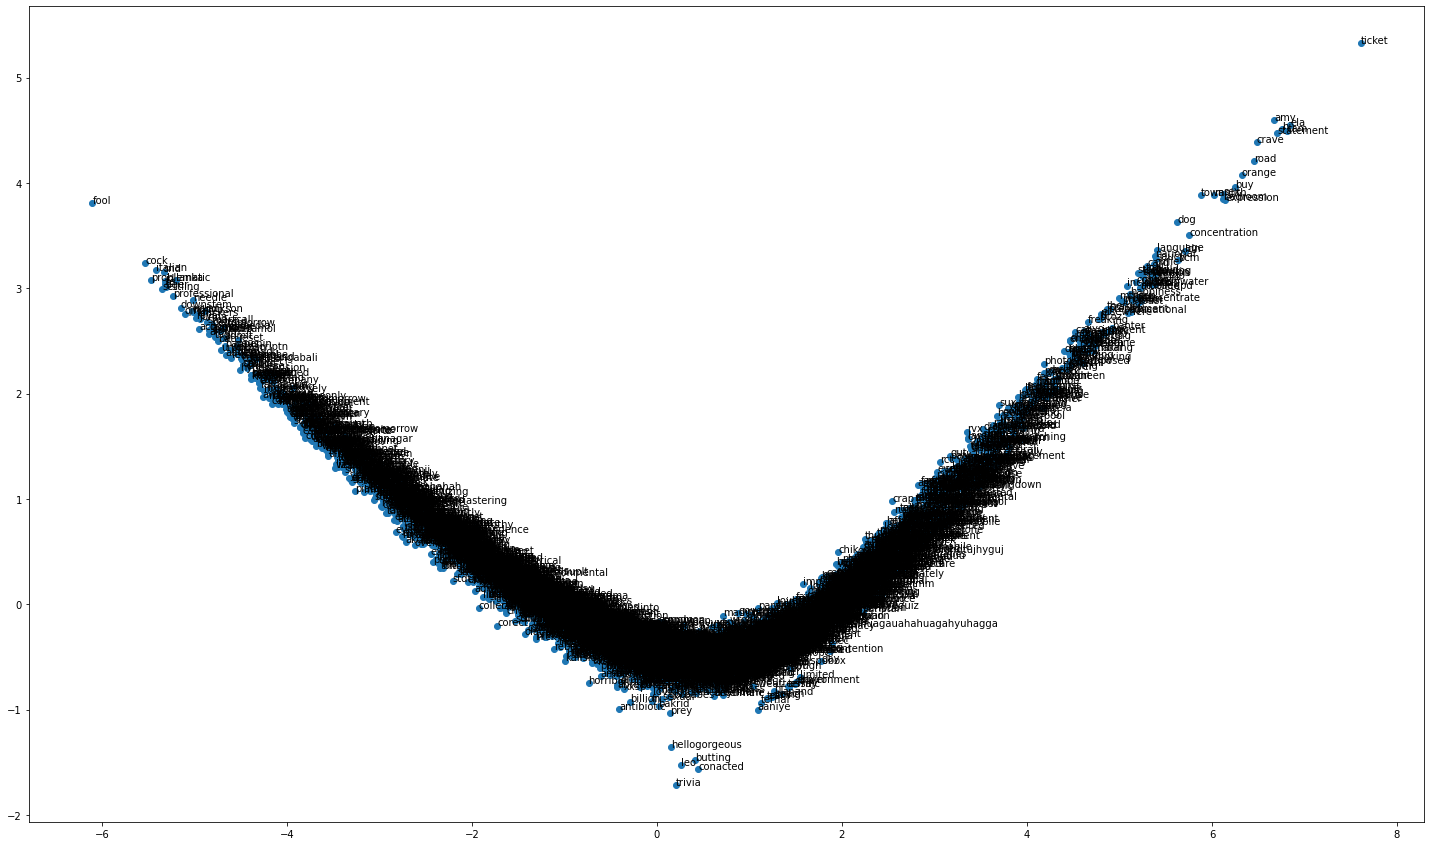

In [106]:
def plot_graph(vocabs, xs, ys):
    plt.figure(figsize=(25, 15))
    plt.scatter(xs, ys, marker='o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))
plot_graph(SkGram_vocabs, xs, ys)

#### TSNE

In [110]:
from sklearn.manifold import TSNE

model2 = TSNE(learning_rate=100)
trandformed = model2.fit_transform(SkGram_vectors)

xs2 = trandformed[:,0]
ys2 = trandformed[:,1]

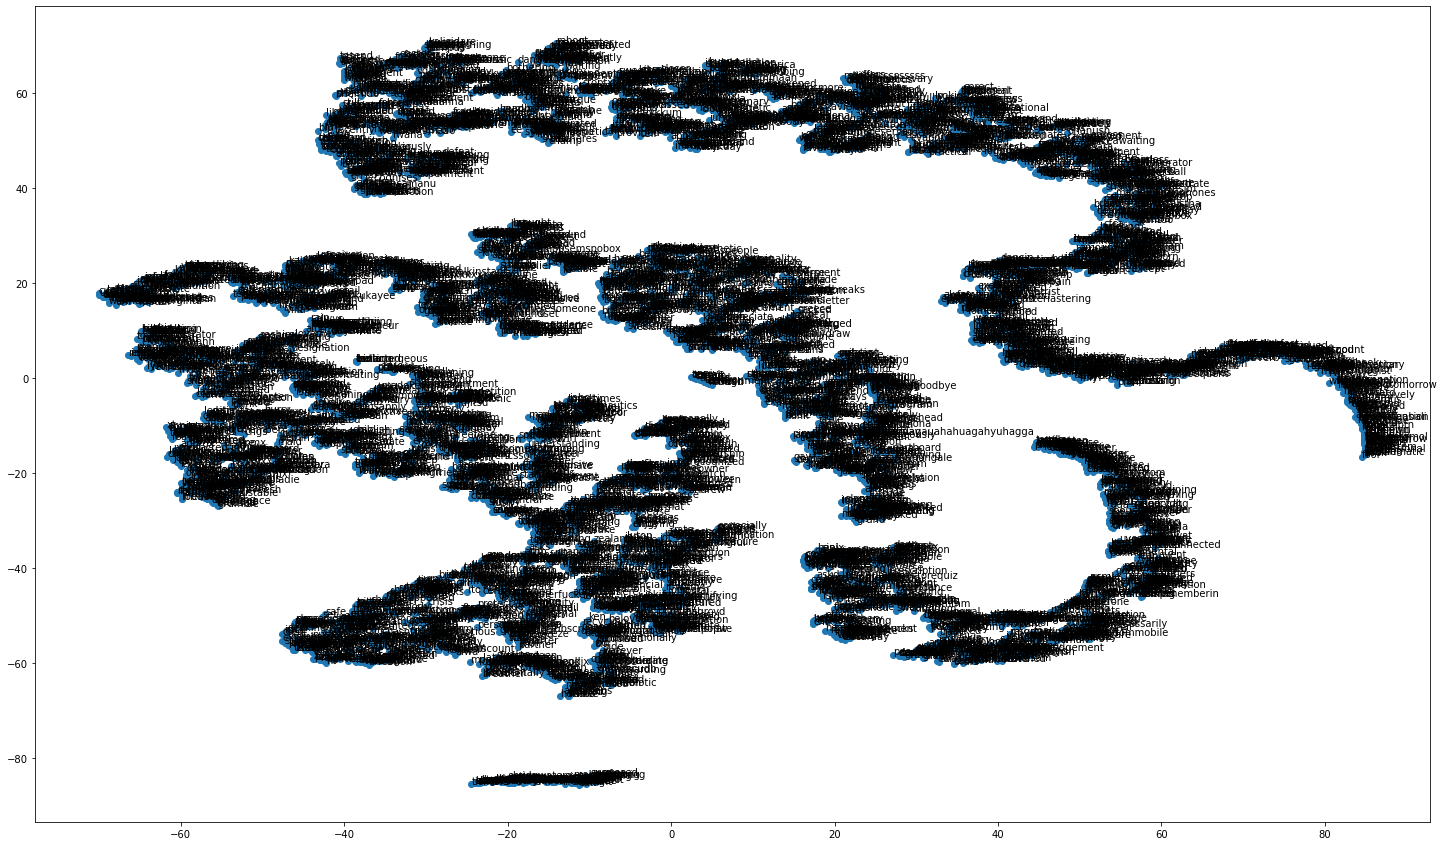

In [111]:
def plot_graph2(vocabs, xs2, ys2):
    plt.figure(figsize=(25, 15))
    plt.scatter(xs2, ys2, marker='o')

    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs2[i], ys2[i]))
plot_graph2(SkGram_vocabs, xs2, ys2)

데이터가 너무 많아서, pca와 tsne로 확인하기 어렵다.. 직접 정확도를 구해보자

In [107]:
Tfidf = TfidfVectorizer("english")

vector = []
for i in token:
    sentence = ""
    for j in i:
        sentence = sentence + j + " " 
    vector.append(sentence)

X_vector = Tfidf.fit_transform(vector)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass input=english as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_vector,spam.v1,test_size=0.3, random_state=222)

RF = RandomForestClassifier()
RF.fit(X_train, y_train)
prediction = RF.predict(X_test)

accuracy_score(y_test,prediction)

0.9819471308833011

분류모델을 돌려 정확도를 확인하기 위해 TF-IDF를 통한 벡터화를 진행하였다. 0.982의 정확도로 상당히 높은 값을 얻었다.